[View in Colaboratory](https://colab.research.google.com/github/3catz/time_series_LSTMS/blob/master/Huang_Hilbert_LSTM_timeseries_forecasting.ipynb)

# Introduction: Time Series Analysis using Huang-Hilbert transforms to decompose series and denoise it before feeding it through a LSTM network with Attention Layers for one point forecasting/prediction.

In [1]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#import pandas_datareader.data as web
from pandas import Series
from pandas import DataFrame
from pandas import concat

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint

#keras 
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer

Using TensorFlow backend.


# Utilities: hurst exponent, series to supervised, attention with context

In [80]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [81]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
   

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]



In [67]:
# hurst exponent
!pip install pandas-datareader
import pandas as pd
from datetime import datetime
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

def hurst(ts):

    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    # Here it calculates the variances, but why it uses 
    # standard deviation and then make a root of it?
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# Loading Data 

In [65]:
import numpy as np
import matplotlib.pyplot as plt
!wget http://www.comp-engine.org/timeseries/query-csv?q=20557



--2018-07-08 21:54:50--  http://www.comp-engine.org/timeseries/query-csv?q=20557
Resolving www.comp-engine.org (www.comp-engine.org)... 155.198.64.5, 146.179.40.5, 2001:630:12:600:1:2:0:7, ...
Connecting to www.comp-engine.org (www.comp-engine.org)|155.198.64.5|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.comp-engine.org/timeseries/query-csv/?q=20557 [following]
--2018-07-08 21:54:52--  http://www.comp-engine.org/timeseries/query-csv/?q=20557
Reusing existing connection to www.comp-engine.org:80.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/dat]
Saving to: ‘query-csv?q=20557.4’

query-csv?q=20557.4     [ <=>                ]  36.91K  --.-KB/s    in 0.1s    

2018-07-08 21:54:53 (366 KB/s) - ‘query-csv?q=20557.4’ saved [37799]



(5000,)


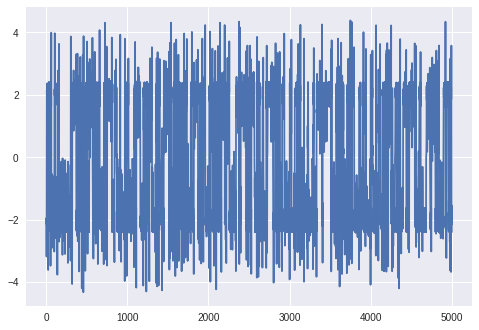

In [118]:
x = np.genfromtxt("query-csv?q=20557.2", delimiter = ",")
plt.plot(x)
print(x.shape)

#**Huang-Hilbert Transform**

Mode 2, Iteration 900
1 minima > 0; 1153 maxima < 0.
Mode 2, Iteration 1200
1 minima > 0; 1151 maxima < 0.
Mode 2, Iteration 1500
0 minima > 0; 1155 maxima < 0.
Mode 2, Iteration 1800
1 minima > 0; 1158 maxima < 0.
Mode 3, Iteration 2100
1 minima > 0; 832 maxima < 0.
Mode 3, Iteration 2400
1 minima > 0; 843 maxima < 0.
Mode 10, Iteration 2700
0 minima > 0; 13 maxima < 0.
2
3
4
5
6
7
8
9
10
11
12
13
14


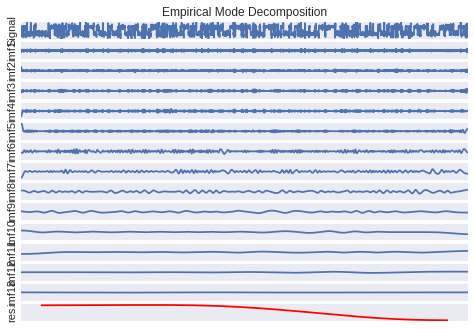

In [68]:
from pyhht.emd import EMD 
from pyhht.visualization import plot_imfs
decomposer = EMD(x, maxiter = 3000)
imfs = decomposer.decompose()
plot_imfs(x, imfs)

Calculate the hurst exponents for each IMF

In [70]:
for i in range(len(imfs)):
  print(hurst(imfs[i]))

0.001458333617057197
-0.012790586681449478
-0.02092950242352804
-0.00217619056877337
0.0568161864071332
0.10702411419739462
0.28085570191165077
0.4567106609400064
0.8534805889402575
0.966297853300661
0.9864409231644667
0.9980010426245537
1.0019271492261754
0.9993554136536587


Caclulate the kurtosis of each IMF

In [72]:
from scipy.stats import kurtosis
for i in range(len(imfs)):
  print(kurtosis(imfs[i]))

0.11137283338574333
6.772347952672339
1.6694461446896556
8.633198537493312
55.98886136505929
0.33467972718442685
6.325633543154256
-0.3481132498373314
-0.7535821016239437
4.04634225742406
3.1841234890961587
-0.3166059731241875
-1.239582773881429
-1.2233822251079443


## Remove the 2 IMFs and that have Gaussian kurtosis ie IMF10 and 11

## Reconstructing the signal after removing Gaussian like IMFs


<function matplotlib.pyplot.show>

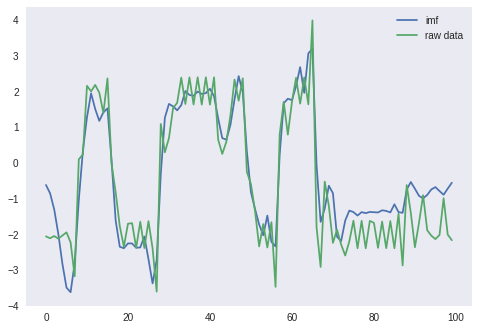

In [102]:
signal = imfs[1]+imfs[2]+imfs[3]+imfs[4]+imfs[5]+imfs[6]+imfs[7]
plt.plot(signal[0:100], label = "imf")
rd = np.genfromtxt("query-csv?q=20557", delimiter = ",")
plt.plot(rd[0:100], label = "raw data")

plt.grid()
plt.legend()
plt.show

hurst shows that the original series is switching between high and low values 
the later IMFs are high autocorrelation


# partial autocorrelation graph

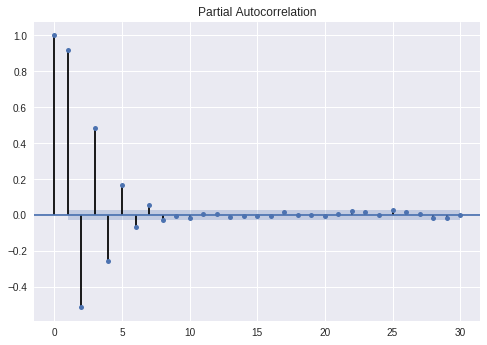

In [85]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(signal, lags = 30, alpha = .05, use_vlines = True)
plt.show()

In [119]:
n_in = 10
n_out = 1 
dp = 0.6
epochs = 50
bsize = 64



# Rescale data and make supervised training/validation/test set

In [121]:

scaler = MinMaxScaler(feature_range = (-1,1))
signal = signal.reshape(-1,1)
signal_scaled= scaler.fit_transform(signal)
signal_df = series_to_supervised(signal_scaled, n_in, n_out, dropnan = True)
signal_df = np.array(signal_df)

In [126]:
train, test = train_test_split(signal_df, shuffle = False, test_size = 0.2)
valid, test = train_test_split(test, shuffle = False)
train.shape, valid.shape, test.shape

trainX = train[:,:-n_out]
trainY = train[:,-n_out:]
testX = test[:,:-n_out]
testY = test[:,-n_out:]
validX = valid[:,:-n_out]
validY = valid[:,-n_out:]

trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])
validX = validX.reshape(validX.shape[0], 1, validX.shape[1])
print(trainX.shape, validX.shape, testX.shape, trainY.shape, validY.shape, testY.shape)

(3992, 1, 10) (748, 1, 10) (250, 1, 10) (3992, 1) (748, 1) (250, 1)


In [127]:
from keras.layers.advanced_activations import *
from keras.regularizers import l2 
n1 = 32
inputs = Input(shape = (1, n_in))
#first recurrent unit
x = LSTM(n1, return_sequences = True, 
         dropout = dp, recurrent_dropout = dp, 
         input_shape = inputs.shape)(inputs)

x = LSTM(n1, return_sequences = True)(x)
x = AttentionWithContext()(x)
x = Reshape((1,n1))(x)
x = LSTM(n1, return_sequences = True)(x)
x = AttentionWithContext()(x)
x = Reshape((1,n1))(x)
x = AttentionWithContext()(x)

predictions = Dense(n_out, activation = "tanh")(x)

base_model = Model(inputs = inputs, outputs = predictions)


opt = adam(lr = 1e-3)


#callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor = 0.8, patience = 6, min_lr = 9e-4, verbose = 2)
checkpointer = ModelCheckpoint(filepath = "stochastic_sine_LSTM.hdf5", verbose = 1, save_best_only = True)
early = EarlyStopping(monitor='val_loss', min_delta = 1e-5, patience = 10, verbose = 1, mode = 'auto')

base_model.compile(optimizer=opt, 
              loss='mse',
              metrics=["accuracy"])
base_model.summary()

base_history = base_model.fit(trainX, trainY, 
          epochs = epochs, 
          batch_size = bsize, 
          verbose = 2, 
          validation_data = (validX, validY),
          callbacks = [reduce_lr, early],
          shuffle = False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 1, 10)             0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 1, 32)             5504      
_________________________________________________________________
lstm_32 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
attention_with_context_30 (A (None, 32)                1088      
_________________________________________________________________
reshape_20 (Reshape)         (None, 1, 32)             0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
attention_with_context_31 (A (None, 32)                1088      
__________

 - 2s - loss: 0.0672 - acc: 0.0000e+00 - val_loss: 0.0647 - val_acc: 0.0000e+00
Epoch 20/50
 - 2s - loss: 0.0658 - acc: 0.0000e+00 - val_loss: 0.0668 - val_acc: 0.0000e+00
Epoch 21/50
 - 2s - loss: 0.0636 - acc: 2.5050e-04 - val_loss: 0.0651 - val_acc: 0.0000e+00
Epoch 22/50
 - 2s - loss: 0.0626 - acc: 0.0000e+00 - val_loss: 0.0656 - val_acc: 0.0000e+00
Epoch 23/50
 - 2s - loss: 0.0631 - acc: 2.5050e-04 - val_loss: 0.0686 - val_acc: 0.0000e+00
Epoch 24/50
 - 2s - loss: 0.0634 - acc: 2.5050e-04 - val_loss: 0.0687 - val_acc: 0.0000e+00
Epoch 00024: early stopping


Final R2 Score is:0.6012055995123979


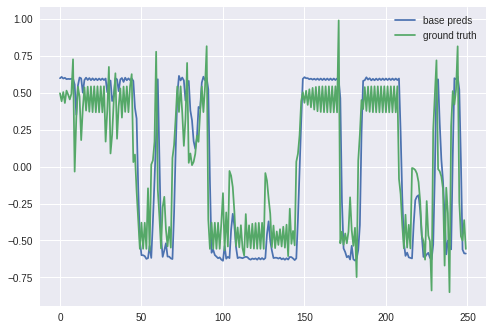

In [128]:
base_preds = base_model.predict(testX, batch_size = 64)


plt.plot(base_preds, label = "base preds")
plt.plot(testY, label = "ground truth")
print("Final R2 Score is:" + str(r2_score(testY, base_preds)))
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()

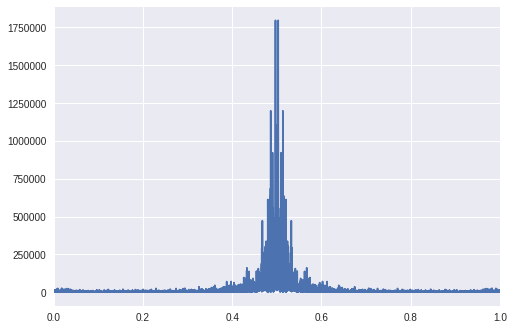

In [74]:
X = np.fft.fftshift(np.fft.fft(x))
plt.xlim([0,1])
plt.plot(np.linspace(0,1, 5000), np.abs(X) ** 2)

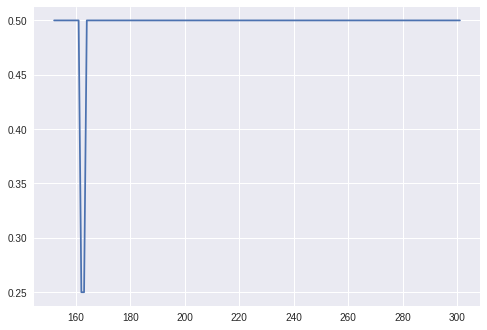

In [73]:
from pyhht.utils import inst_freq
instf, timestamps = inst_freq(x)

a = 150; b = 300
plt.plot(timestamps[a:b], instf[a:b])